## Step 1.1: Install Packages and Libraries

In [1]:
!pip install mesh_to_sdf
!apt-get install xvfb
!pip install pyvirtualdisplay

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
"""
Step 1.1: Install Necessary Packages and Libraries
"""

from IPython import get_ipython
from IPython.display import display

import torch
from torch import nn
from mesh_to_sdf import sample_sdf_near_surface
import trimesh
from torch.utils.data import DataLoader, Dataset
import numpy as np
from math import sqrt
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## Step 1.2 Prepare Training Dataset

In [3]:
"""
Step 1.2: Prepare the Training Dataset from Input Mesh
"""

class NeuralSDFDataset(Dataset):
    def __init__(self, mesh_path, sample_num, device='cuda'):
        """
        In this function, we first use a package called `trimesh` (it's already imported in Step 1.1) to load an `.obj` file with path <code>mesh_path</code>
        We then sample sample_num points around the surface by calling method `sample_sdf_near_surface`.

        Your task is to convert the sampled points and their sdf values (with the type of `numpy ndarray`) to torch tensors by calling the `torch.from_numpy` function.
        After conversion, you will send those tensors to CUDA GPU by calling the `.to(device)` function.
        The converted device tensors should be stored in self.points and self.sdf in separate.
        """
        mesh = trimesh.load(mesh_path)
        points, sdf = sample_sdf_near_surface(mesh, number_of_points=sample_num)

        ### you implementation starts

        self.points = torch.from_numpy(points).to(device)
        self.sdf = torch.from_numpy(sdf).to(device)

        ### you implementation ends


    def __len__(self):
        return 1 # we are not using this

    def __getitem__(self, idx):
        return self.points, self.sdf

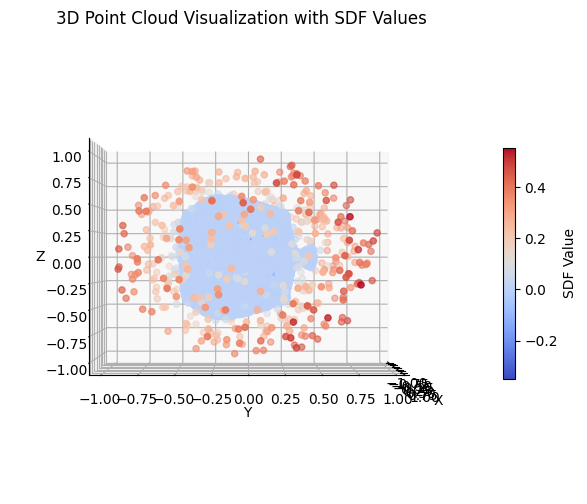

In [4]:
"""
This block is a checkpoint for you Step 1.2 implementation. Run the block to check the plot of the sample point distribution and make sure it is consistent with the input shape.
There is no implementation requirement within this block.
"""

### Helper method for test result of the sampled points from your dataset class.
def test_dataset(sdf_loader_test):
  points, sdf = next(iter(sdf_loader_test))
  points =  points.cpu().detach().numpy().squeeze(0)
  sdf = sdf.cpu().detach().numpy().squeeze()
  norm = plt.Normalize(vmin=np.min(sdf), vmax=np.max(sdf))
  colors = plt.cm.coolwarm(norm(sdf))
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')

  sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=sdf, cmap='coolwarm', marker='o')

  cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
  cbar.set_label("SDF Value")

  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")
  ax.set_title("3D Point Cloud Visualization with SDF Values")
  ax.view_init(elev=0, azim=0)
  plt.show()


sample_num = 10000
device='cuda'
mesh_path="mymodel.obj" ### Change to bunny.obj if needed.

sdf_test = NeuralSDFDataset(mesh_path, sample_num, device=device)
sdf_loader_test = DataLoader(sdf_test, num_workers=0)
test_dataset(sdf_loader_test)

## Step 1.3 Network Structure

In [5]:
"""
Step 1.3: Neural Network Structure for SDF Representation
"""

class SineLayer(nn.Module):
    """
    Default sin activation frequency w0 is set to be 30, feel free to play with it.
    However, we set this to be 15 by default due to our network is much smaller that suffers from learning high frequency features.
    If you have time, make the hidden layers to 512 width with 5 depth, then checkout the difference.

    By default, the weights for the first layer are initialized differently as suggested in Sec.3.2 in the original paper. We use is_first flag to
    check whether we should init the weights differently.

    We use linear layer as the last layer without any activation functions since SDF values shouldn't be limited to a certain range.
    We use is_last flag to check if we should use activation functions or not.
    """

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, is_last=False, w0=15, skip_weight=1):
        """
        In this function, you are tasked to initialize the fully-connectd layer self.fc using the feature vectors with their sizes specified by in_featuers and out_features
        """

        super().__init__()
        self.w0 = w0                         # a float specifying the default frequency in activation function
        self.is_first = is_first             # a boolean flag indicating if the layer is the first layer
        self.is_last = is_last               # a boolean flag indicating if the layer is the last layer
        self.skip_weight = skip_weight       # a float weight controlling skip connection
        self.in_features = in_features       # an integer specifying the size of the input feature vector
        self.out_features = out_features     # an integer specifying the size of the output feature vector
        self.fc = None                       # fully connected layer; None as default

        ### your implementation starts

        self.fc = nn.Linear(in_features, out_features, bias=bias)

        ### your implementation ends

        self.init_weights()

    def init_weights(self):
        """
        This function initializes the weights for the first layer and other layers (see details in the Deep SDF paper Sec.3.2).
        No implementation is required in this function.
        """
        with torch.no_grad():
            if self.is_first:
                self.fc.weight.uniform_(-1. / self.in_features,
                                             1. / self.in_features)
            else:
                self.fc.weight.uniform_(-np.sqrt(6 / self.in_features) / self.w0,
                                             np.sqrt(6 / self.in_features) / self.w0)

    def forward(self, x):
        """
        You are tasked to implement the activation function by using the output of the fully connected layer taking x.
        The implementation should consists of three cases: the first layer, the last layer, and the intermediate layer(s).
            - If the layer is the first layer, you should apply the sine activation function to the output of the fully connected layer with w0 as its frequency;
            - If the layer is the last layer, you should take the output of the fully connected layer as the final output;
            - If the layer is an intermediate layer, you should add the output from the sine activation function weighted by skip_weight to the original x.
        """
        ### your implementation starts

        fc_output = self.fc(x)

        if self.is_first:
            return torch.sin(self.w0 * fc_output)
        elif self.is_last:
            return fc_output
        else:
            return torch.sin(self.w0 * fc_output) / self.skip_weight + x


        ### your implementation ends

class NeuralSDF(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, w0=30):
        super().__init__()

        """
        You are tasked to initialize all the layers in the neural network, including the first layer, the intermediate layer(s), and the last layer.
        The initialized network layers will be stored in the list of nn.
        Make sure to use the input arguments of the init function when initializing these layers.
        """

        self.network = []                               # a list storing all the layers; empty by default
        self.w0 = w0                                    # a float specifying the activation function frequency
        self.hidden_features = hidden_features          # an integer specifying the size of the hidden-layer feature vector
        self.hidden_layers = hidden_layers              # an integer specifying specifying the number of hidden layers
        self.in_features = in_features                  # an integer specifying the size of the input feature vector
        self.out_features = out_features                # an integer specifying the size of the output feature vector

        ### your implementation starts

        self.network.append(SineLayer(in_features=in_features, out_features=hidden_features, is_first=True, w0=w0))
        for i in range(self.hidden_layers):
            self.network.append(SineLayer(in_features=hidden_features, out_features=hidden_features, w0=w0, skip_weight=sqrt(i+1)))
        self.network.append(SineLayer(in_features=hidden_features, out_features=out_features, is_last=True, w0=w0))

        ### your implementation ends

        self.network = nn.Sequential(*self.network)

    def forward(self, x):
        output = self.network(x)
        return output

## Step 1.4 Train Your Network

In [6]:
"""
Step 1.4: Train Your Neural Network with Adam Optimizer
"""
def train_neuralSDF(dataloader, hidden_features, hidden_layers, w0, lr=1e-4, iterations=10000, device='cuda'):
    """
    You are tasked to implement the training loop of the neural network.
    For each epoch, you will start with a zero gradient and use the Mean Squared Loss (MSE) as your loss function.
    Then, you need to propagate the loss backward and run the optimization step function provided by the optimizer.
    """

    model = NeuralSDF(in_features=3, out_features=1, hidden_features=hidden_features, hidden_layers=hidden_layers, w0=w0).to(device)
    optimizer = torch.optim.Adam(lr=lr, params=model.parameters(), weight_decay=.0)
    data, labels = next(iter(dataloader))

    for epoch in range(iterations):

        ### your implementation starts

        optimizer.zero_grad()
        output = model(data)
        loss = nn.MSELoss()(output[0].squeeze(dim=1), labels[0])
        loss.backward()
        optimizer.step()

        ### your implementation ends

        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    return model

In [7]:
"""
sample_num: total points sampled (feel free to increase this if needed)
mesh_path: relative path to .obj file location
"""

sample_num = 80000  ### total number of points sampled as training points, feel free to change this.
device='cuda'
mesh_path="mymodel.obj" ### mesh path to your mesh,

sdf = NeuralSDFDataset(mesh_path, sample_num, device=device)
sdfloader = DataLoader(sdf, num_workers=0)

In [11]:
"""
hidden_features: hidden layer width.
hidden_layers: hidden layer depth.
w0: Activation frequency. We suggest 15 for our given examples.

Feel free to play around with these parameters.
"""
hidden_features = 16 ### hidden layer width, feel free to change
hidden_layers = 3 ### hidden layer depth, feel free to change
w0 = 15 ### activation function frequency, feel free to change
iterations = 40000 ### total number of training iterations, feel free to change
lr = 1e-5 ### learning rate, feel free to change

neural_sdf = train_neuralSDF(sdfloader, hidden_features = hidden_features, hidden_layers = hidden_layers, w0 = w0, lr=lr, iterations=iterations, device=device)

Epoch 1, Loss: 0.030672630295157433
Epoch 101, Loss: 0.020358514040708542
Epoch 201, Loss: 0.014556679874658585
Epoch 301, Loss: 0.011268066242337227
Epoch 401, Loss: 0.009328782558441162
Epoch 501, Loss: 0.008108583278954029
Epoch 601, Loss: 0.007273162715137005
Epoch 701, Loss: 0.0066516464576125145
Epoch 801, Loss: 0.006156989838927984
Epoch 901, Loss: 0.005742919165641069
Epoch 1001, Loss: 0.005382642149925232
Epoch 1101, Loss: 0.0050593046471476555
Epoch 1201, Loss: 0.004762076307088137
Epoch 1301, Loss: 0.004484199453145266
Epoch 1401, Loss: 0.004221420735120773
Epoch 1501, Loss: 0.003970802295953035
Epoch 1601, Loss: 0.0037301916163414717
Epoch 1701, Loss: 0.0034982177894562483
Epoch 1801, Loss: 0.0032743574120104313
Epoch 1901, Loss: 0.003058708505704999
Epoch 2001, Loss: 0.0028515360318124294
Epoch 2101, Loss: 0.0026529442984610796
Epoch 2201, Loss: 0.0024629246909171343
Epoch 2301, Loss: 0.0022815647535026073
Epoch 2401, Loss: 0.002109133405610919
Epoch 2501, Loss: 0.00194598

## Step 2 Copy Network Weights to Shader

In [12]:

"""
Run this step to generate the text file for the neural network weights.
The generated weights will be printed to the Notebook output.
There is no implementation requirement for this section.

The neural SDF to ShaderToy conversion were modified based on Blackle Mori's Neural Stanford Bunny: https://www.shadertoy.com/view/wtVyWK
"""

import re

### Helper function for convert pytorch cuda tensor to numpy arrays
def dump_data(dat):
  dat = dat.cpu().detach().numpy()
  return dat

### Print a vector to a form that's usable in fragement shader
def print_vec4(ws):
  vec = "vec4(" + ",".join(["{0:.2f}".format(w) for w in ws]) + ")"
  vec = re.sub(r"\b0\.", ".", vec)
  return vec

### Print a matrix to a form that's usable in fragement shader
def print_mat4(ws):
  mat = "mat4(" + ",".join(["{0:.2f}".format(w) for w in np.transpose(ws).flatten()]) + ")"
  mat = re.sub(r"\b0\.", ".", mat)
  return mat

### Since we know networks are just matrices and vectors, this function converts our network to matrices and vectors that
### can be compiled in fragement shader.
def serialize_to_shadertoy(network, varname):
  omega = network.w0
  chunks = int(network.hidden_features/4)
  lin = network.network[0].fc
  in_w = dump_data(lin.weight)
  in_bias = dump_data(lin.bias)
  om = omega
  for row in range(chunks):
    line = "vec4 %s0_%d=sin(" % (varname, row)
    for ft in range(network.in_features):
        feature = x_vec = in_w[row*4:(row+1)*4,ft]*om
        line += ("p.%s*" % ["y","z","x"][ft]) + print_vec4(feature) + "+"
    bias = in_bias[row*4:(row+1)*4]*om
    line += print_vec4(bias) + ");"
    print(line)

  #hidden layers
  for layer in range(network.hidden_layers):
    layer_w = dump_data(network.network[layer+1].fc.weight)
    layer_bias = dump_data(network.network[layer+1].fc.bias)
    for row in range(chunks):
      line = ("vec4 %s%d_%d" % (varname, layer+1, row)) + "=sin("
      for col in range(chunks):
        mat = layer_w[row*4:(row+1)*4,col*4:(col+1)*4]*omega
        line += print_mat4(mat) + ("*%s%d_%d"%(varname, layer, col)) + "+\n    "
      bias = layer_bias[row*4:(row+1)*4]*omega
      line += print_vec4(bias)+")/%0.1f+%s%d_%d;"%(sqrt(layer+1), varname, layer, row)
      print(line)

  #output layer
  out_w = dump_data(network.network[-1].fc.weight)
  out_bias = dump_data(network.network[-1].fc.bias)
  for outf in range(network.out_features):
    line = "return "
    for row in range(chunks):
      vec = out_w[outf,row*4:(row+1)*4]
      line += ("dot(%s%d_%d,"%(varname, network.hidden_layers, row)) + print_vec4(vec) + ")+\n    "
    print(line + "{:0.3f}".format(out_bias[outf])+";")

In [13]:
serialize_to_shadertoy(neural_sdf, 'f')

vec4 f0_0=sin(p.y*vec4(-4.26,-2.40,3.72,-3.55)+p.z*vec4(1.22,-3.93,-.11,.37)+p.x*vec4(-1.82,4.01,-2.51,1.63)+vec4(-6.47,-5.37,-1.26,5.56));
vec4 f0_1=sin(p.y*vec4(-3.04,-2.33,-3.90,-.31)+p.z*vec4(-2.67,2.20,1.73,3.97)+p.x*vec4(-.88,2.18,-.82,-2.59)+vec4(-2.99,.02,-2.43,-1.59));
vec4 f0_2=sin(p.y*vec4(1.20,3.49,3.17,-4.28)+p.z*vec4(-3.38,2.63,2.23,2.51)+p.x*vec4(1.30,.86,-2.48,-4.22)+vec4(-2.75,-3.92,-6.66,-7.60));
vec4 f0_3=sin(p.y*vec4(-.76,1.07,2.04,-2.31)+p.z*vec4(2.89,1.87,1.82,-.12)+p.x*vec4(1.78,-2.92,3.50,-1.53)+vec4(5.02,7.68,-6.63,.43));
vec4 f1_0=sin(mat4(-.38,-.56,.23,.39,.29,-.77,.05,.12,.06,.58,-.35,.60,.23,-.08,.00,.77)*f0_0+
    mat4(.16,-.25,.65,.39,-.20,.02,.14,-.30,.45,-.11,.03,.24,.13,.20,.33,-.56)*f0_1+
    mat4(.18,-.46,.09,.52,-.26,.04,1.34,.26,.22,-.19,-.07,.37,-.19,-.11,-.04,-.01)*f0_2+
    mat4(.66,-.03,-.82,.12,-.26,-.14,.42,-.42,.26,.05,-.42,.29,.91,-.16,-.07,.58)*f0_3+
    vec4(.14,.20,-2.35,-2.18))/1.0+f0_0;
vec4 f1_1=sin(mat4(-.33,-.31,-.10,-.46,-.03,-.42,